In [300]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

# Task 1. Algorithm's analysis

In [301]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

import time
from tqdm import tqdm

### Generating graph

In [302]:

# You can use this function to generate a random graph with 'num_of_nodes'
# nodes and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted
    (in case of undirected graphs)
    """


    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))

    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)

    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)

    if draw:
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue',
                    with_labels=True,
                    node_size=500,
                    arrowsize=20,
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)

        else:
            nx.draw(G, node_color='lightblue',
                with_labels=True,
                node_size=500)

    return G

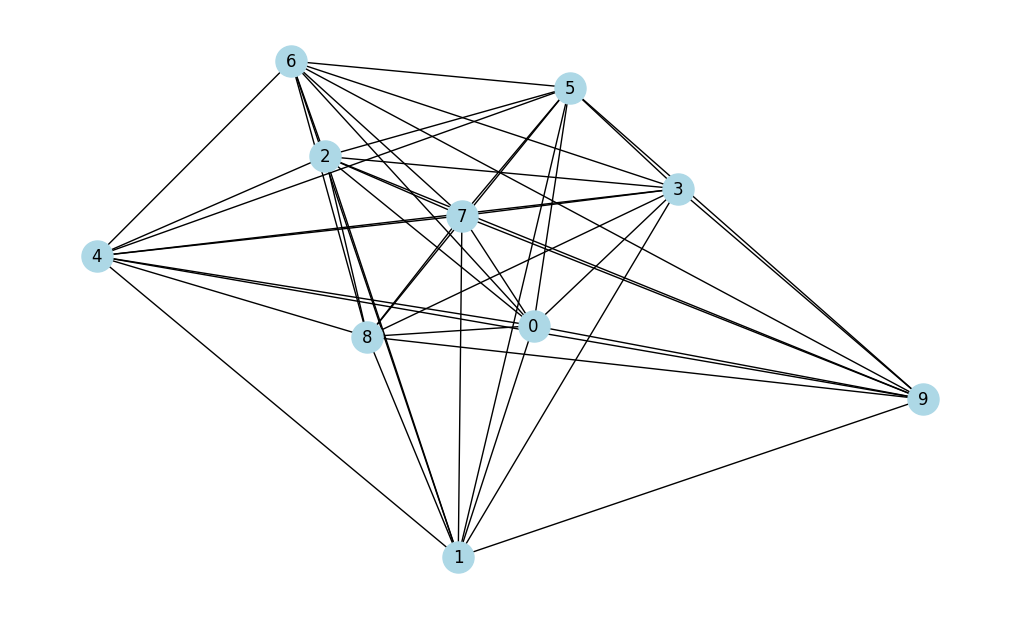

In [303]:
G = gnp_random_connected_graph(10, 1, False, True)

## Subtask 1.1 (1 point)

### Kruskal's algorithm

#### nx implementation

In [304]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

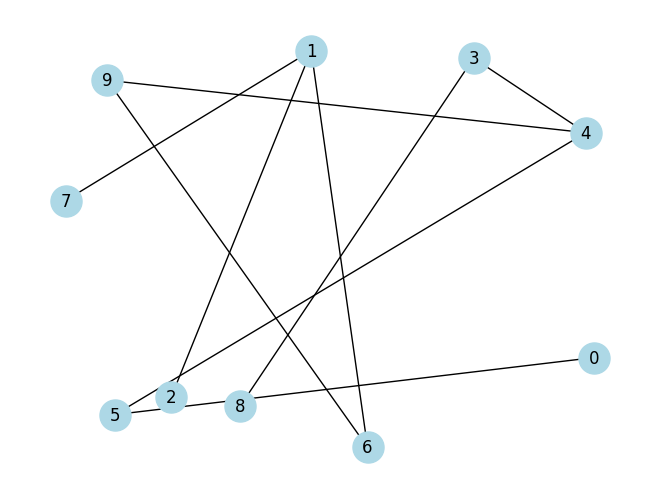

In [305]:
nx.draw(mstk, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [306]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 5), (1, 6), (1, 2), (1, 7), (3, 8), (3, 4), (4, 9), (4, 5), (6, 9)]),
 9)

In [307]:
class DSU:
    """Disjoint Set Union"""
    def __init__(self, n):
        self.father = list(range(n))
        self.height = [0] * n

    def find(self, x):
        """find root with compression"""
        if self.father[x] != x:
            self.father[x] = self.find(self.father[x])
        return self.father[x]

    def union(self, v_1, v_2):
        """union by height"""
        root_1 = self.find(v_1)
        root_2 = self.find(v_2)

        if root_1 == root_2:
            return False

        if self.height[root_1] < self.height[root_2]:
            self.father[root_1] = root_2
        elif self.height[root_1] > self.height[root_2]:
            self.father[root_2] = root_1
        else:
            self.father[root_2] = root_1
            self.height[root_1] += 1
        return True


def kruskal_algorithm(graph):
    """
    Kruskal's algorithm. Find Minimum Spanning Tree(MST).
    Uses DSU for cycle detection
    """
    nodes = list(graph.nodes())
    edges = []

    # all edges
    for u, v, data in graph.edges(data=True):
        weight = data.get('weight', 1)
        edges.append((weight, u, v))

    edges.sort()

    # node: index
    node_to_idx = {node: i for i, node in enumerate(nodes)}

    dsu = DSU(len(nodes))
    mst_edges = []

    for weight, u, v in edges:
        # different components
        if dsu.union(node_to_idx[u], node_to_idx[v]):
            mst_edges.append((u, v, weight))
            # n-1 edge
            if len(mst_edges) == len(nodes) - 1:
                break
    return mst_edges

### Prim's algorithm

#### nx implementation

In [308]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

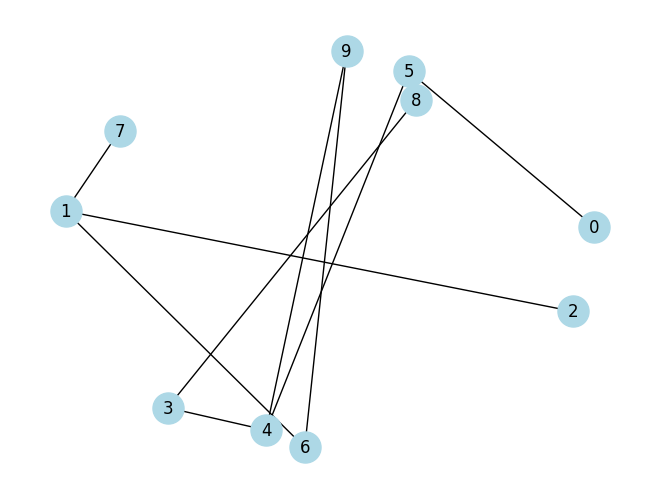

In [309]:
nx.draw(mstp, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [310]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 5), (1, 6), (1, 2), (1, 7), (3, 4), (3, 8), (4, 5), (4, 9), (6, 9)]),
 9)

In [311]:
def prim_algorithm(graph):
    nodes = list(graph.nodes())
    if not nodes:
        return []


    starting_node = nodes[0]

    visited_nodes = {starting_node}
    the_edges = []

    while len(visited_nodes) < len(nodes):
        min_weight = float("inf")
        best_edge = None

        for u in visited_nodes:
            for v, info in graph[u].items():
                if v not in visited_nodes:
                    weight = info.get("weight", 1)
                    if weight < min_weight:
                        min_weight = weight
                        best_edge = (u, v, weight)

        if best_edge:
            visited_nodes.add(best_edge[1])
            the_edges.append(best_edge)
        else:
            break

    return the_edges


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# **Experiments: Prim vs Kruskal**



In [312]:
GRAPH_SIZES = [5, 10, 20, 50, 100, 200]
COMPLETENESS = 0.4
ITERATIONS = 30

# Measure Prim vs Kruskal
prim_times = []
kruskal_times = []
nx_prim_times = []
nx_kruskal_times = []

for n in GRAPH_SIZES:
    prim_total = 0
    kruskal_total = 0
    nx_prim_total = 0
    nx_kruskal_total = 0

    for _ in tqdm(range(ITERATIONS), desc=f"Size {n}"):

        G = gnp_random_connected_graph(n, COMPLETENESS, False)

        # Our Prim
        start = time.time()
        prim_algorithm(G)
        prim_total += time.time() - start

        # Our Kruskal
        start = time.time()
        kruskal_algorithm(G)
        kruskal_total += time.time() - start

        # NetworkX Prim
        start = time.time()
        tree.minimum_spanning_tree(G, algorithm="prim")
        nx_prim_total += time.time() - start

        # NetworkX Kruskal
        start = time.time()
        tree.minimum_spanning_tree(G, algorithm="kruskal")
        nx_kruskal_total += time.time() - start

    prim_times.append(prim_total / ITERATIONS)
    kruskal_times.append(kruskal_total / ITERATIONS)
    nx_prim_times.append(nx_prim_total / ITERATIONS)
    nx_kruskal_times.append(nx_kruskal_total / ITERATIONS)


Size 200: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


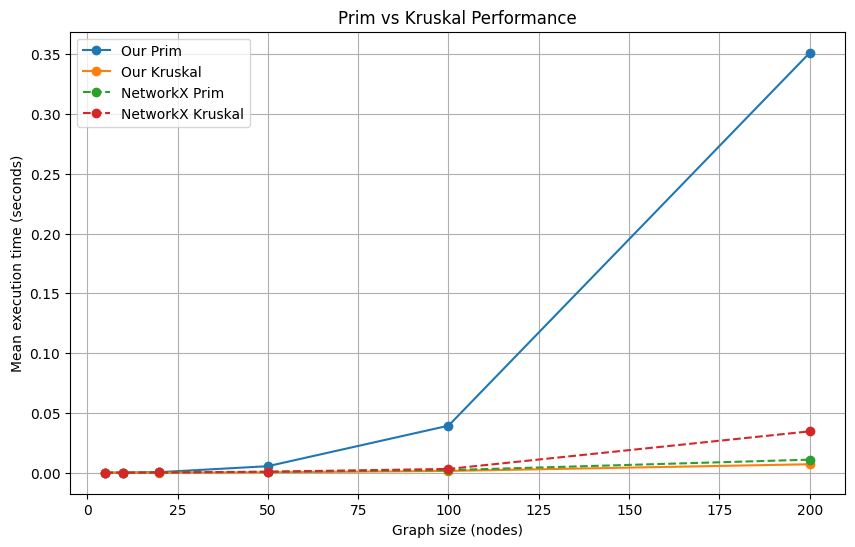

In [313]:
plt.figure(figsize=(10,6))

plt.plot(GRAPH_SIZES, prim_times, marker='o', label="Our Prim")
plt.plot(GRAPH_SIZES, kruskal_times, marker='o', label="Our Kruskal")
plt.plot(GRAPH_SIZES, nx_prim_times, marker='o', linestyle='--', label="NetworkX Prim")
plt.plot(GRAPH_SIZES, nx_kruskal_times, marker='o', linestyle='--', label="NetworkX Kruskal")

plt.xlabel("Graph size (nodes)")
plt.ylabel("Mean execution time (seconds)")
plt.title("Prim vs Kruskal Performance")
plt.legend()
plt.grid()
plt.show()


**Висновки по “Prim vs Kruskal”**

Наш Prim показав значно більший час виконання, ніж інші алгоритми.
Причина цього: у нашій реалізації ми на кожному кроці перебираємо всі ребра, що ведуть з уже відвіданих вузлів, щоб знайти мінімальне.
Тобто складність у найгіршому випадку близька до O(V^2) для щільного графа (коли багато ребер). Через це на великих графах (100–200 вузлів) час росте дуже швидко, що і видно на графіку.
Для прискорення треба використовувати priority queue / heap, як це робить NetworkX, тоді складність зменшиться і час стане порівнянним з Kruskal. Наш Kruskal працює дуже швидко і стабільно навіть на великих графах.
Тут велика заслуга DSU для перевірки циклів - ми уникаємо зайвих ітерацій і швидко визначаємо, чи можна додати ребро.
Через це наш Kruskal часто перевершує навіть NetworkX, особливо на графах з невеликою щільністю.
NetworkX теж використовує оптимізації, але наша Python-реалізація DSU із union-by-rank і path compression працює надзвичайно ефективно на цих розмірах.
NetworkX Prim і Kruskal показують очікувано низький час виконання.
Вони оптимізовані на рівні C: використовується heap для Прима і швидка структура ребер для Крускала.
Завдяки цьому вони ростуть дуже повільно, навіть на великих графах.

## Subtask 1.2 (1 point)

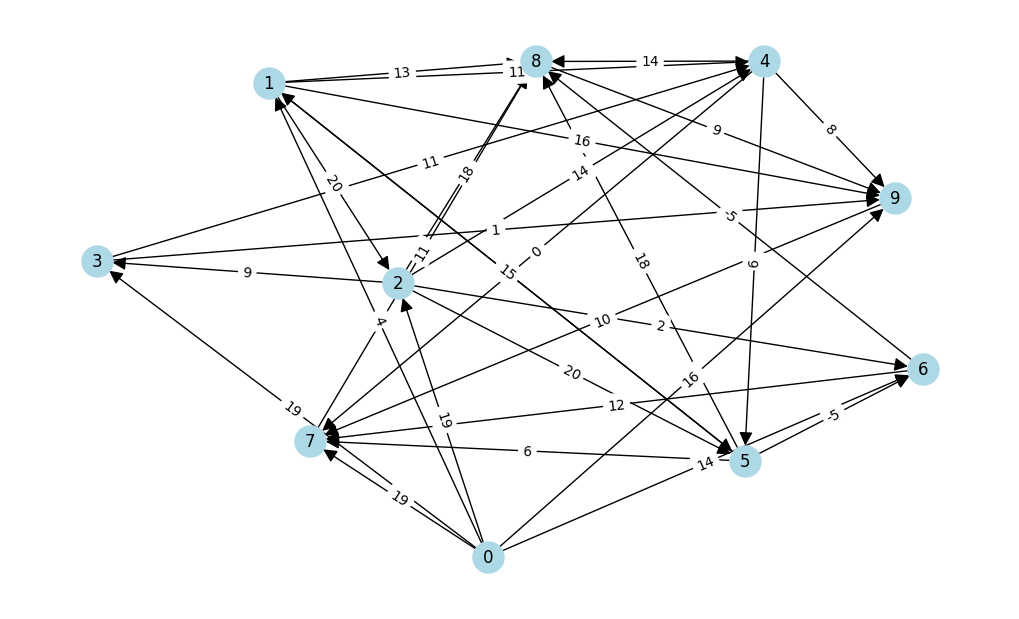

In [314]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### Bellman-Ford algorithm

#### nx implementation

In [315]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 1: 4
Distance to 2: 19
Distance to 3: 19
Distance to 6: -3
Distance to 7: 8
Distance to 9: 1
Distance to 4: 15
Distance to 5: 2
Distance to 8: -8


In [316]:
def bellman_ford_algorithm(graph, source):
    """
    Bellman-Ford algorithm for finding shortest paths from source vertex

    Time complexity: O(V * E) where V is vertices, E is edges
    Returns: (distances, predecessors) or raises error if negative cycle exists
    """
    nodes = list(graph.nodes())
    distances = {node: float('inf') for node in nodes}
    predecessors = {node: None for node in nodes}
    distances[source] = 0

    # Relax edges |V| - 1 times
    for _ in range(len(nodes) - 1):
        for u, v, data in graph.edges(data=True):
            weight = data.get('weight', 1)
            if distances[u] != float('inf') and distances[u] + weight < distances[v]:
                distances[v] = distances[u] + weight
                predecessors[v] = u

    # Check for negative cycles
    for u, v, data in graph.edges(data=True):
        weight = data.get('weight', 1)
        if distances[u] != float('inf') and distances[u] + weight < distances[v]:
            raise ValueError("Graph contains a negative-weight cycle")

    return predecessors, distances

### Floyd-Warshall algorithm

#### nx implementation

In [317]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G)
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Distances with 0 source: {0: 0, 1: 4, 2: 19, 3: 19, 6: -3, 7: 8, 9: 1, 4: 15, 5: 2, 8: -8}
Distances with 1 source: {1: 0, 2: 20, 4: 11, 5: -2, 8: -12, 9: -3, 0: inf, 3: 29, 6: -7, 7: 4}
Distances with 2 source: {2: 0, 6: 2, 3: 9, 4: 14, 5: 20, 8: -3, 0: inf, 1: 35, 7: 14, 9: 6}
Distances with 3 source: {3: 0, 4: 11, 9: 1, 0: inf, 1: 32, 2: 52, 5: 17, 6: 12, 7: 11, 8: 7}
Distances with 4 source: {4: 0, 7: 0, 5: 6, 8: -4, 9: 5, 0: inf, 1: 21, 2: 41, 3: 50, 6: 1}
Distances with 5 source: {5: 0, 1: 15, 6: -5, 7: 6, 8: -10, 0: inf, 2: 35, 3: 44, 4: 26, 9: -1}
Distances with 6 source: {6: 0, 8: -5, 7: 12, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 9: 4}
Distances with 7 source: {7: 0, 8: 11, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 9: 20}
Distances with 8 source: {8: 0, 9: 9, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: 19}
Distances with 9 source: {9: 0, 7: 10, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 8: 21}


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

Graph size 200: 100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


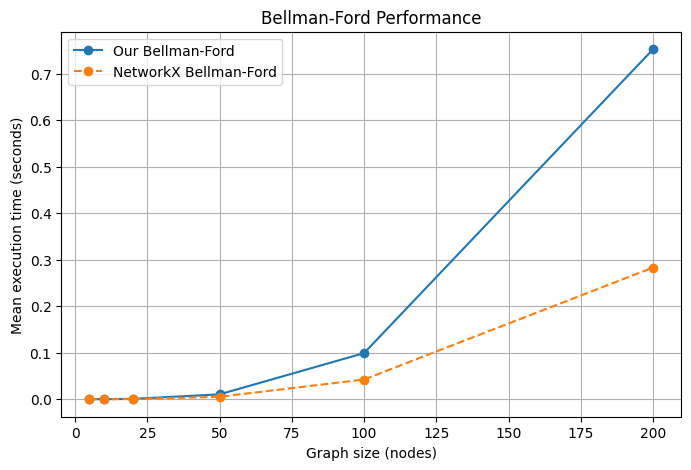

In [318]:
SIZES = [5, 10, 20, 50, 100, 200]
NUM_OF_ITERATIONS = 50

our_times = []
nx_times = []

for n in SIZES:
    our_total = 0
    nx_total = 0

    for _ in tqdm(range(NUM_OF_ITERATIONS), desc=f"Graph size {n}"):

        G = gnp_random_connected_graph(n, 0.4, directed=True)

        # Our Bellman-Ford
        start = time.time()
        try:
            bellman_ford_algorithm(G, 0)
        except ValueError:
            pass  # negative cycle
        end = time.time()
        our_total += (end - start)

        # NetworkX Bellman-Ford
        start = time.time()
        try:
            bellman_ford_predecessor_and_distance(G, 0)
        except:
            pass
        end = time.time()
        nx_total += (end - start)

    our_times.append(our_total / NUM_OF_ITERATIONS)
    nx_times.append(nx_total / NUM_OF_ITERATIONS)


plt.figure(figsize=(8,5))
plt.plot(SIZES, our_times, marker='o', label="Our Bellman-Ford")
plt.plot(SIZES, nx_times, marker='o', linestyle='--', label="NetworkX Bellman-Ford")

plt.xlabel("Graph size (nodes)")
plt.ylabel("Mean execution time (seconds)")
plt.title("Bellman-Ford Performance")
plt.legend()
plt.grid(True)
plt.show()

**Висновки по “BelmanFord”**


Наш Bellman/Ford показав помітно більший час виконання, ніж реалізація NetworkX, і різниця швидко росте зі збільшенням розміру графа. Причина цього — сама природа алгоритму: у нашій реалізації ми виконуємо релаксацію всіх ребер V−1 разів. Тобто складність алгоритму становить
O(V * E), тому коли граф стає більшим (особливо якщо він досить щільний), кількість операцій різко зростає. Саме тому на графах 100–200 вузлів час виконання починає рости дуже швидко, що чітко видно на графіку. Ми добре дослідили тему, та зрозуміли, що пробелема не в нашій реалізації, а це фундаментальна властивість BellmanFord алгоритму.

Наша реалізація працює коректно і стабільно - алгоритм правильно знаходить найкоротші шляхи навіть при наявності від’ємних ваг, а також коректно визначає від’ємні цикли. Основний час витрачається саме на багаторазову релаксацію ребер, і тут ми не знайшли можливості суттєво зменшити складність без зміни самого алгоритму.

NetworkX Bellman–Ford працює швидше, але різниця не така радикальна, як у випадку з Prim. Це пояснюється тим, що bottleneck тут — не Python, а сама асимптотика алгоритму. NetworkX має оптимізовані структури даних і менший оверхед, тому виграє по часу, але обидві реалізації ростуть приблизно з однаковою швидкістю.

Підсумовуючи, Bellman–Ford значно повільніший за MST алгоритми які ми реалізували (Prim і Kruskal), але його головна перевага — підтримка від’ємних ваг і можливість виявлення від’ємних циклів. Саме тому він залишається необхідним для задач найкоротших шляхів у графах, де Dijkstra не може бути використаний.

# Task 2. Decision Tree Classifier

In [319]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## General idea


You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://medium.com/data-science/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575

Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Dataset

You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set

However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.

P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

In [320]:
# Load dataset
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [321]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [322]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

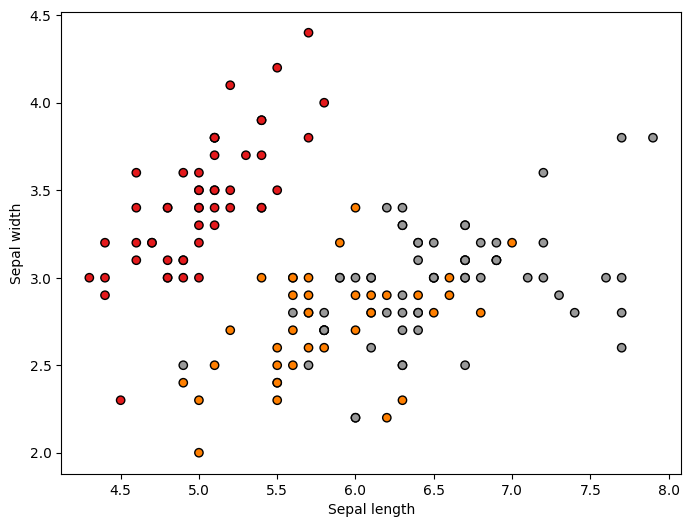

In [323]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage

**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [324]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [325]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [326]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [327]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("iris")

'iris.pdf'

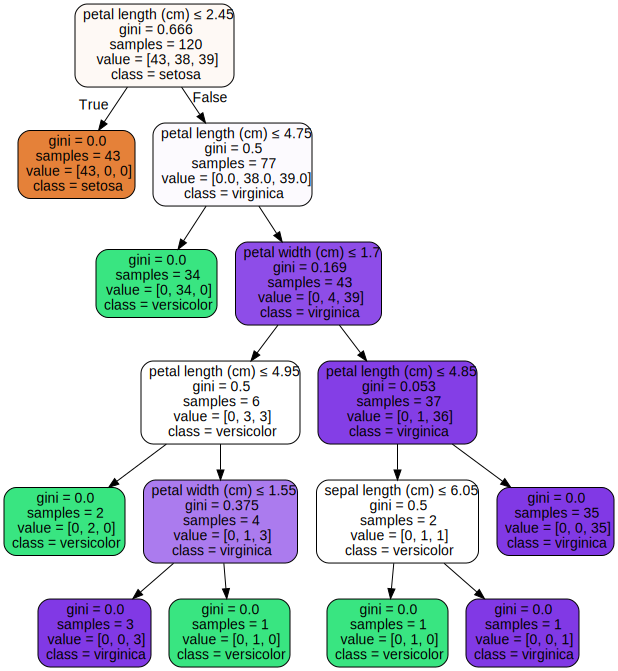

In [328]:
dot_data = tree.export_graphviz(clf, out_file=None,
                     feature_names=iris.feature_names,
                     class_names=iris.target_names,
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [329]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [330]:
sum(predictions == y_test) / len(y_test)

np.float64(0.8666666666666667)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [331]:
y_test

array([2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 0,
       1, 0, 0, 2, 2, 0, 1, 0])


Here you can traverse the tree above by yourself and make sure that prediction works

In [332]:
X_test[1]

array([4.4, 3. , 1.3, 0.2])

In [333]:
clf.predict([X_test[1]])

array([0])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Decision tree classifier (2 point)

###  Gini impurity


Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$


### Your implementation

> We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.

In [ ]:
#Creating function for gini

def gini(y: npt.NDArray) -> float:
    if len(y) == 0:
         return 0.0

    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

In [ ]:

class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

#count data that appear more often and decides
        if len(y) > 0:
            self.value = np.bincount(y).argmax()
        else:
            self.value = 0

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None


    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = np.unique(y).size
        self.tree = self._grow_tree(X, y, depth=0)


    def _grow_tree(self, X, y, depth):
        """
        Recursive function that builds the Decision Tree node by node.

       Briefly it:
        1. Creates a new Node for the current data.
        2. Checks stopping criteria (Base Cases):
           - Max depth reached
           - All samples belong to the same class (pure node)
           - Not enough samples to split further
           If yes, returns the leaf node.
        3. Finds the best feature and threshold to split data using `_best_split`.
        4. Recursively calls itself to build the Left and Right subtrees.
        """
        node = Node(X, y)
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))
        if (depth >= self.max_depth or num_labels == 1 or num_samples < 2):
            return node

        best_split = self._best_split(X, y, num_features)
        if not best_split:
            return node

        node.feature_index = best_split['feature_idx']
        node.threshold = best_split['threshold']
        #recursion for lest tree
        node.left = self._grow_tree(
            X[best_split['left_indices']],
            y[best_split['left_indices']],
            depth + 1
        )
        #recursion for right tree
        node.right = self._grow_tree(
            X[~best_split['left_indices']],
            y[~best_split['left_indices']],
            depth + 1
        )

        return node



    def _best_split(self, X, y, num_features):
        """
        Iterates through all features and thresholds to find the optimal split.
        """
        best_gini = float('inf')
        best_split = None
        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] < threshold
                if np.sum(left_mask) == 0 or np.sum(~left_mask) == 0:
                    continue

                gini_l = gini(y[left_mask])
                gini_r = gini(y[~left_mask])

                len_l, len_r = len(y[left_mask]), len(y[~left_mask])
                weighted_gini = (len_l * gini_l + len_r * gini_r) / len(y)

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_split = {
                        'feature_idx': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_mask
                    }

        return best_split


    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it
        """
        def predict(self, X_test):
            predictions = []
            for x in X_test:
                node = self.tree

                while node.left:
                    if x[node.feature_index] < node.threshold:
                        node = node.left
                    else:
                        node = node.right
                predictions.append(node.value)

            return predictions

In [ ]:

def evaluate(X_test: list[list], y_test: list, tree) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    predictions = tree.predict(X_test)

    correct_guesses = 0
    the_total_samples = len(y_test)
    for i in range(the_total_samples):
        if predictions[i] == y_test[i]:
            correct_guesses += 1

    accuracy = correct_guesses / the_total_samples
    return accuracy

**Результат:**

In [ ]:
score = evaluate(X_test, y_test, tree)
print(f"ТОчність дерева: {score}")

#### Additional point (+0.5)

Use Laplace smoothing, explain what is the point of using it